In [1]:
%matplotlib inline

In [2]:
import numpy as np
from vtk_rw import read_vtk
from sklearn import linear_model
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt

### prepare data

### adapt this to full brain data! ###

In [3]:
mesh_file = '/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/%s_lowres_new.vtk'
mask_file = '/scr/ilz3/myelinconnect/new_groupavg/masks/%s_fullmask.npy'
t1_file = '/scr/ilz3/myelinconnect/new_groupavg/t1/%s/%s_t1_avg_%s.npy'
embed_dict_file = '/scr/ilz3/myelinconnect/new_groupavg/embed/%s_%s_embed_dict.pkl'
model_file = '/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/%s_%s_t1avg_by_fc_maps_%s.pkl'

In [4]:
hemi = 'lh'
smooth='smooth_3'

In [5]:
v,f,d = read_vtk(mesh_file%hemi)
t1 = np.load(t1_file%(smooth, hemi, smooth))
mask = np.load(mask_file%hemi)

# prepare embedding (normalized from entry in dict)
pkl_in = open(embed_dict_file%(hemi,smooth), 'r')
embed_dict=pickle.load(pkl_in)
pkl_in.close()

embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(10):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,v.shape[0])
nonmask=np.delete(idcs, mask)
embed = np.zeros((v.shape[0],10))
embed[nonmask] = embed_masked

# extend mask to nodes that have a t1avg < 1500
mask = np.unique(np.concatenate((mask,np.where(t1<=1500)[0])))
mask = np.asarray(mask, dtype='int64')
nonmask_bigmask=np.delete(idcs, mask)

masked_t1 = np.delete(t1, mask)
masked_embed = np.delete(embed, mask, axis=0)

### run single model

In [6]:
maps = [0,1]

In [7]:
clf = linear_model.LinearRegression()
clf.fit(masked_embed[:,maps], masked_t1)

modelled_fit = clf.predict(masked_embed[:,maps])
residuals = masked_t1 - clf.predict(masked_embed[:,maps])

### calculate BIC for model

χ2==∑iNr2i (sum over i in N of r(i)^2)

bic==Nln(χ2/N)+2NvarysNln(χ2/N)+ln(N)∗Nvarys

where r is the residual array returned by the objective function (likely to be (data-model)/uncertainty for data modeling usages), N is the number of data points (ndata), and Nvarys is number of variable parameters.

http://cars9.uchicago.edu/software/python/lmfit/fitting.html#fit-results-label

https://en.wikipedia.org/wiki/Bayesian_information_criterion

In [84]:
def BIC(residuals, n_free):
    n = residuals.shape[0]
    chisquare = np.sum(residuals**2)
    bic = n* np.log(chisquare/n) + np.log(n) * n_free
    return bic

### iterate over all possible models

In [86]:
import itertools

In [87]:
maps = range(10)
combinations = []

for i in range(len(maps)):
    element = [list(x) for x in itertools.combinations(maps, i+1)]
    combinations.extend(element)

In [88]:
len(combinations)

1023

In [89]:
import pandas as pd

In [90]:
df = pd.DataFrame(columns=["Maps", "Pearson's r", "R squared", "BIC"], index=range(len(combinations)))

In [91]:
for c in range(len(combinations)):
    maps=combinations[c]
    clf = linear_model.LinearRegression()
    clf.fit(masked_embed[:,maps], masked_t1)

    modelled_fit = clf.predict(masked_embed[:,maps])
    residuals = masked_t1 - clf.predict(masked_embed[:,maps])
    
    df["Maps"][c] = tuple(maps)
    df["Pearson's r"][c] = stats.pearsonr(modelled_fit, masked_t1)
    df["R squared"][c] = clf.score(masked_embed[:,maps], masked_t1)
    df["BIC"][c] = BIC(residuals, len(maps))
    


In [94]:
np.argmin(df["BIC"])

1022

In [95]:
df.iloc[1022]

Maps           (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
Pearson's r             (0.782393125899, 0.0)
R squared                            0.612139
BIC                                  550654.5
Name: 1022, dtype: object

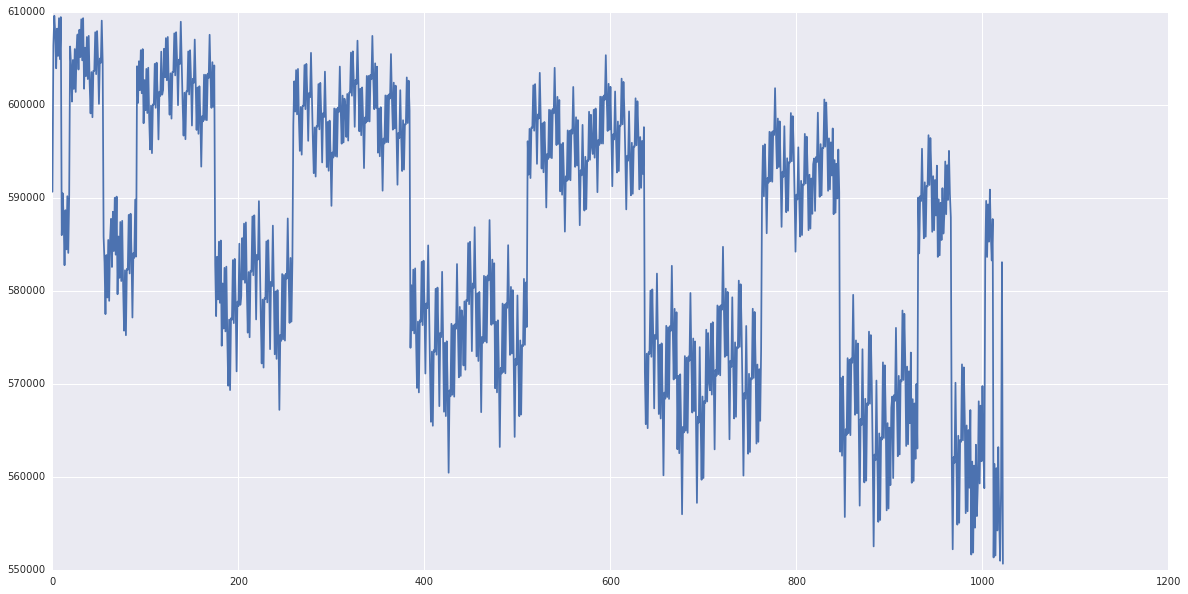

In [99]:
import seaborn as sns
fig = plt.figure(figsize=(20,10))
plt.plot(df["BIC"])

In [97]:
df.iloc(0)

590654.46542484825

In [101]:
df.tail(20)

,Maps,Pearson's r,R squared,BIC
1003,"(1, 2, 3, 4, 5, 6, 7, 8)","(0.586372152037, 0.0)",0.3438323,583465.6
1004,"(1, 2, 3, 4, 5, 6, 7, 9)","(0.524700994968, 0.0)",0.2753111,589668.3
1005,"(1, 2, 3, 4, 5, 6, 8, 9)","(0.584815782319, 0.0)",0.3420095,583638.9
1006,"(1, 2, 3, 4, 5, 7, 8, 9)","(0.528833724051, 0.0)",0.2796651,589292
1007,"(1, 2, 3, 4, 6, 7, 8, 9)","(0.569610470851, 0.0)",0.3244561,585283
1008,"(1, 2, 3, 5, 6, 7, 8, 9)","(0.510992989104, 0.0)",0.2611138,590879.9
1009,"(1, 2, 4, 5, 6, 7, 8, 9)","(0.562931259583, 0.0)",0.3168916,585978.4
1010,"(1, 3, 4, 5, 6, 7, 8, 9)","(0.588210222575, 0.0)",0.3459913,583259.8
1011,"(2, 3, 4, 5, 6, 7, 8, 9)","(0.545517985104, 0.0)",0.2975899,587718.4
1012,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","(0.779657730696, 0.0)",0.6078662,551327.6
